<a href="https://colab.research.google.com/github/Victor0vich/Denis/blob/main/LLM_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 1: Large Language Models

In [ ]:
%pip install --quiet transformers==4.47.1

import gc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import subprocess
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 50.5 MB/s eta 0:00:00


Для создания семинара использовались материалы ШАД и курса Александра Шабалина.

## Closed-Source модели

Сейчас большинство SoTA-решений является Closed-Source, и доступны только через веб-интерфейс, или через API с жесткими ограничениями. Удобно, если нужно прогнать несколько вопросов - попробуйте сами.


- OpenAI API (через VPN) - [openai.com/api](https://openai.com/api/)
- Chatbot Arena (удобный способ попробовать топовые LLMки, но с очень строгими ограничениями) - [chat.lmsys.org](https://chat.lmsys.org)
- YandexGPT Lite/Pro (поддерживает дообучение) - [console.yandex.cloud](https://console.yandex.cloud/folders/b1g4lgsfdsvocob346tv/foundation-models/overview)
- GigaChat API (без дообучения) - [developers.sber.ru](https://developers.sber.ru/docs/ru/gigachat/api/overview)


Но в демо-режиме особо не разгонишься, и ничего не автоматизируешь. Для масштабного применения придется платить за доступ к API. Как быть, если хотим классные модели, но бесплатно?

## Open-Source модели

К счастью, тут спасают модели с открытым исходным кодом. Удобнее всего их искать на [HuggingFace](https://huggingface.co/models?pipeline_tag=text-generation&sort=trending) или на уже упомянутом [ChatBot Arena](https://chat.lmsys.org) - во вкладке LeaderBoard искать модели с открытыми лицензиями. Примеры:

- [ruGPT-3.5](https://huggingface.co/ai-forever/ruGPT-3.5-13B)
- [GigaChat-20B-A3B-instruct](https://huggingface.co/ai-sage/GigaChat-20B-A3B-instruct)
- [Meta-Llama-3-8B](https://huggingface.co/meta-llama/Meta-Llama-3-8B) (требует HF token)
- [Mistral-7B-Instruct](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2) (требует HF token)

Будем работать со следующими моделями:

-   [Qwen2.5-7B](https://huggingface.co/Qwen/Qwen2.5-7B)
-   [OpenChat-3.5](https://huggingface.co/openchat/openchat-3.5-0106)
-   [gpt2](https://huggingface.co/openai-community/gpt2)



### Загрузка модели

Давайте попробуем подгрузить и использовать такую модель. Сразу предупреждаю - мы будем мучать GPU, беспощадно. Не забудьте поставить GPU в среде выполнения.

In [ ]:
!nvidia-smi

Fri May 23 08:57:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
model_name = 'openchat/openchat-3.5-0106'

tokenizer = transformers.LlamaTokenizer.from_pretrained(model_name, device_map=device)
tokenizer.pad_token_id = tokenizer.eos_token_id

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    offload_state_dict=True,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Можем заметить, что мы уже заняли 13 ГБ из доступных 15. Далее действовать нужно очень осторожно.

In [ ]:
!nvidia-smi

Tue May  6 15:48:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P0             27W /   70W |   12956MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Генерация

Вспомним, что под капотом это все еще просто генеративная модель, которая предсказывает вероятности следующих токенов. Что делать с этими вероятностями дальше - можно определить с помощью стратегии генерации.

| Стратегия | Описание | Плюсы и минусы |
| --- | --- | --- |
| Greedy Search | Выбирает слово с наивысшей вероятностью как следующее слово в последовательности. | Плюсы: Простота и скорость.<br> Минусы: Может привести к повторяющемуся и несвязному тексту. |
| Семплинг с температурой | Добавляет случайность в выбор слова. Большая температура приводит к большей случайности. | Плюсы: Позволяет исследовать и получать разнообразный результат.<br> Минусы: Высокие температуры могут привести к бессмысленным результатам. |
| Семплинг по ядру (Top-p семплинг) | Выбирает следующее слово из усеченного словаря, "ядра" слов, которые имеют суммарную вероятность, превышающую предустановленный порог (p). | Плюсы: Обеспечивает баланс между разнообразием и качеством.<br> Минусы: Настройка оптимального 'p' может быть затруднительна. |
| Beam Search | Исследует множество гипотез (последовательностей слов) на каждом шаге и сохраняет 'k' наиболее вероятных, где 'k' - ширина луча. | Плюсы: Дает более надежные результаты, чем жадный поиск.<br> Минусы: Может страдать от нехватки разнообразия и приводить к общим ответам. |
| Top-k семплинг | Случайным образом выбирает следующее слово из 'k' слов с самыми высокими вероятностями. | Плюсы: Вводит случайность, увеличивая разнообразие результатов.<br> Минусы: Случайный выбор иногда может привести к менее связному тексту. |
| Нормализация длины | Предотвращает предпочтение модели более коротких последовательностей за счет деления логарифмированных вероятностей на длину последовательности, возведенную в некоторую степень. | Плюсы: Делает более длинные и потенциально более информативные последовательности более вероятными.<br> Минусы: Настройка фактора нормализации может быть сложной. |
| Стохастический Beam Search | Вводит случайность в процесс выбора 'k' гипотез в поиске пучком. | Плюсы: Увеличивает разнообразие в сгенерированном тексте.<br> Минусы: Баланс между разнообразием и качеством может быть сложно управлять. |
| Декодирование с минимальным риском Байеса (MBR) | Выбирает гипотезу (из многих), которая минимизирует ожидаемую потерю для функции потерь. | Плюсы: Оптимизирует результат в соответствии с определенной функцией потерь.<br> Минусы: Вычислительно более сложно и требует хорошо подобранную функциию потерь. |

Референсы:
- [Документация `AutoModelForCausalLM.generate()`](https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationMixin.generate)
- [Документация `AutoTokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode)
- [Статья о стратегиях генерации на Huggingface](https://huggingface.co/docs/transformers/generation_strategies)

In [ ]:
prompt = 'The first known form of life on Mars looked like'
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)
print("Input batch (encoded):", batch)

Input batch (encoded): {'input_ids': tensor([[    1,   415,   907,  2651,  1221,   302,  1411,   356, 15798,  2382,
           737]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}


Greedy Search

In [ ]:
output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=False)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))


Output: <s>The first known form of life on Mars looked like a cross between a mushroom and a sea sponge, according to a new study.

The study, published in the journal Nature, suggests that the first life on Mars was a type of microbial mat, which is a community of microorganisms that live together in a thin layer of slime


# Sampling with temperature

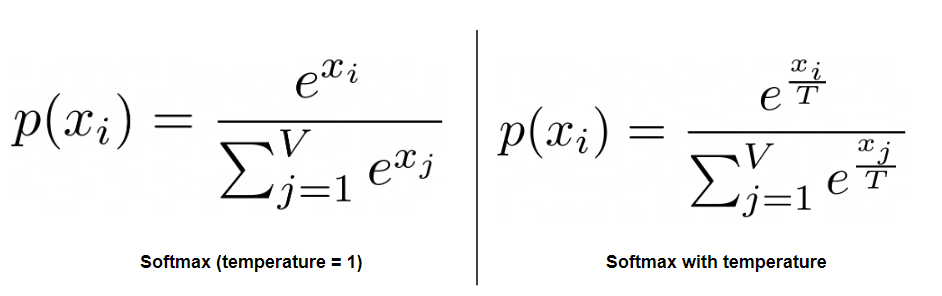

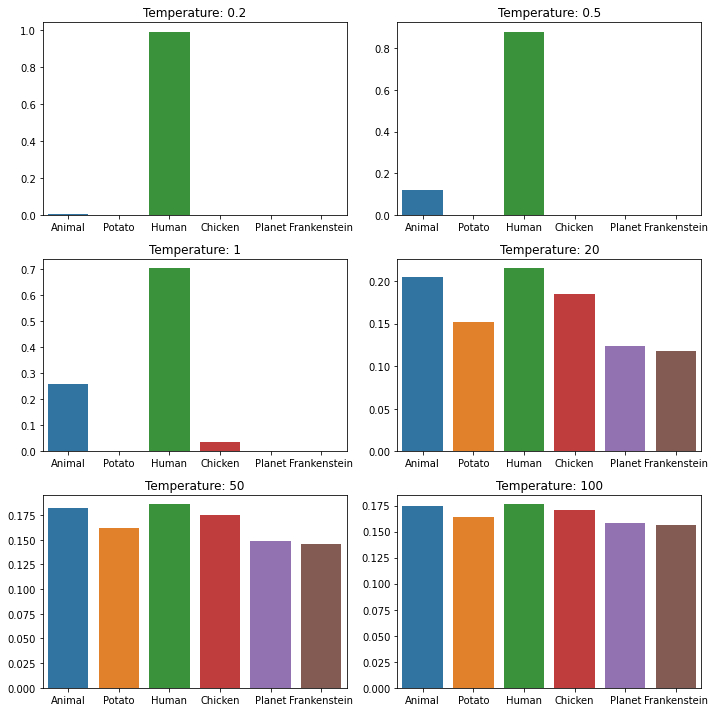

Семплинг с температурой

In [ ]:
output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.7)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))


Output: <s>The first known form of life on Mars looked like a cross between a mushroom and a sea sponge, according to a new study.

The study, published in the journal Nature, suggests that the Martian surface was once covered by a vast ocean that was home to a diverse array of life forms.

Researchers from the University of Edinburgh


Top-K семплинг

In [ ]:
output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.1, top_k=10)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))


Output: <s>The first known form of life on Mars looked like a cross between a mushroom and a sea sponge, according to a new study.

The study, published in the journal Nature, suggests that the first life on Mars was a type of microbial mat, which is a community of microorganisms that live together in a thin layer of slime


Beam Search

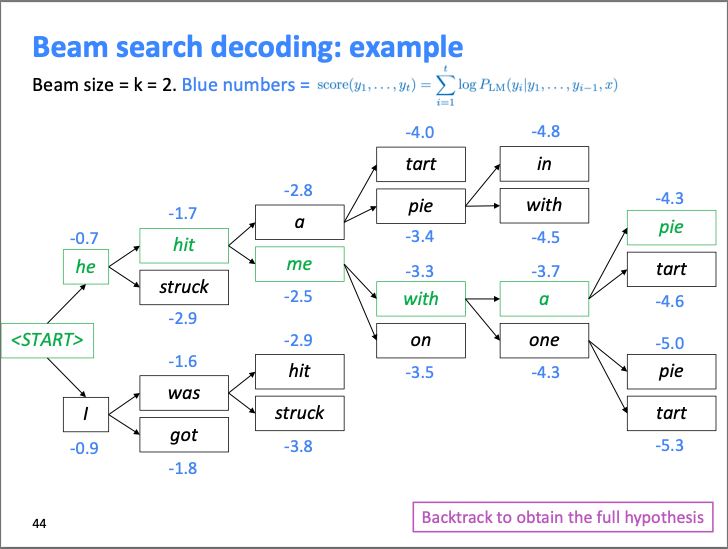

In [ ]:
output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=False, num_beams=3)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))


Output: <s>The first known form of life on Mars looked like a cross between a mushroom and a sea anemone, according to a new study.

The study, published in the journal Nature, suggests that life on the Red Planet began around 3.5 billion years ago, when the planet was much warmer and wetter than it is today.



# Промпты и Chain-of-thought reasoning

Изначально модели заточены на генерацию - чтобы общаться с ними в привычном режиме диалога промпт нужно отформатировать. Правильный формат обычно указан в документации модели, но для некоторых моделей его можно восстановить с помощью метода apply_chat_template

In [ ]:
messages = [
    {"role": "user", "content": "What is your favourite condiment?"},
    {"role": "assistant", "content": "Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen!"},
    {"role": "user", "content": "Do you have mayonnaise recipes?"}
]


In [ ]:
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

In [ ]:
prompt

"<s>GPT4 Correct User: What is your favourite condiment?<|end_of_turn|>GPT4 Correct Assistant: Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen!<|end_of_turn|>GPT4 Correct User: Do you have mayonnaise recipes?<|end_of_turn|>GPT4 Correct Assistant:"

In [ ]:
inputs = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to(device)
output_tokens = model.generate(inputs, do_sample=True, temperature=0.7, max_new_tokens=256)
print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))


Output: <s>GPT4 Correct User: What is your favourite condiment? <|end_of_turn|> GPT4 Correct Assistant: Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen! <|end_of_turn|> GPT4 Correct User: Do you have mayonnaise recipes? <|end_of_turn|> GPT4 Correct Assistant: Absolutely! Mayonnaise is a versatile condiment that can be used in a variety of dishes. Here's a simple recipe for homemade mayonnaise:

Ingredients:
- 1 large egg yolk
- 1 teaspoon Dijon mustard
- 1 teaspoon white wine vinegar or lemon juice
- 1/2 teaspoon salt
- 1/4 teaspoon ground black pepper
- 3/4 cup vegetable oil (such as grapeseed or canola oil)

Instructions:
1. In a medium bowl, whisk together the egg yolk, Dijon mustard, vinegar or lemon juice, salt, and black pepper.
2. Slowly add the vegetable oil in a thin stream, whisking constantly, until the mixture thickens and emulsifies. This process may take a few minutes

У OpenChat есть два варианта ассистента - дефолтный, который реализуется с помощью apply_chat_template, и математический - для его использования нужно использовать имена Math Correct User и Math Correct Assistant.

In [ ]:
messages = [
    {"role": "user", "content": "10.3 − 7988.8133="}
]

prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True).replace('GPT4', 'Math')

print(prompt)

<s>Math Correct User: 10.3 − 7988.8133=<|end_of_turn|>Math Correct Assistant:


### Chain-of-Thought Reasoning

Для оптимальных промптов модели необходимо давать не только примеры ответов, но и снабжать эти примеры детально описанным процессом того, как прийти к этому результату - и при генерации требовать от модели того же.

In [ ]:
prompt = """
GPT4 Correct User:
Question: The original retail price of an appliance was 60 percent more than its wholesale cost. If the appliance was actually sold for 20 percent less than the original retail price, then it was sold for what percent more than its wholesale cost?
Answer Choices: (A) 20% (B) 28% (C) 36% (D) 40% (E) 42% <|end_of_turn|>
GPT4 Correct Assistant:
Rationale: wholesale cost = 100;\noriginal price = 100*1.6 = 160;\nactual price = 160*0.8 = 128.\nAnswer: B.
Correct Answer: B <|end_of_turn|>


GPT4 Correct User:
Question: A grocer makes a 25% profit on the selling price for each bag of flour it sells. If he sells each bag for $100 and makes $3,000 in profit, how many bags did he sell?
Answer Choices: (A) 12 (B) 16 (C) 24 (D) 30 (E) 40 <|end_of_turn|>
GPT4 Correct Assistant:
Rationale: Profit on one bag: 100*1.25= 125\nNumber of bags sold = 3000/125 = 24\nAnswer is C.
Correct Answer: C <|end_of_turn|>


GPT4 Correct User:
Question: 20 marbles were pulled out of a bag of only white marbles, painted black, and then put back in. Then, another 20 marbles were pulled out, of which 1 was black, after which they were all returned to the bag. If the percentage of black marbles pulled out the second time represents their percentage in the bag, how many marbles in total Q does the bag currently hold?
Answer Choices: (A) 40 (B) 200 (C) 380 (D) 400 (E) 3200
GPT4 Correct Assistant:
Rationale: We know that there are 20 black marbles in the bag and this number represent 1/20 th of the number of all marbles in the bag, thus there are total Q of 20*20=400 marbles.\nAnswer: D.
Correct Answer: D <|end_of_turn|>


GPT4 Correct User: Question: Janice bikes at 10 miles per hour, while Jennie bikes at 20. How long until they have collectively biked 1 mile?
Answer Choices: (A) 1 minute (B) 2 minutes (C) 3 minutes (D) 4 minutes (E) 5 minutes
GPT4 Correct Assistant:
Rationale:
""".strip()

In [ ]:
prompt = """Janice bikes at 10 miles per hour, while Jennie bikes at 20. How long until they have collectively biked 1 mile?
Answer Choices: (A) 1 minute (B) 2 minutes (C) 3 minutes (D) 4 minutes (E) 5 minutes
""".strip()

In [ ]:
inputs =  tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)
output_tokens = model.generate(**inputs, do_sample=True, temperature=0.9, max_new_tokens=512)
print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))


Output: <s>Janice bikes at 10 miles per hour, while Jennie bikes at 20. How long until they have collectively biked 1 mile?
Answer Choices: (A) 1 minute (B) 2 minutes (C) 3 minutes (D) 4 minutes (E) 5 minutes
Solution -
Speed of Janice + Speed of Jennie= total speed
10+20=30 miles per hour
Thus, to cover a distance of 1 mile they would need 1/30 of an hour to bike 1 mile together. Since there are 60 minutes in an hour, 1/30 of an hour= 1/30*60= 1.2 minutes.
Correct answer - E.

Note: The distances travelled by each person are not relevant. All that matters is the combined speed. You can visualize this problem as two boats travelling upstream. The rate at which the combined distance is covered doesn't depend on how far up the stream each boat has travelled. All that matters is the combined speed of the boats (or bikers) .
The answer is E. 1 minute.
Alternatively, we could take a more direct approach and use the formula time = distance/rate. If Janice bikes at 10 miles per hour, then sh

In [ ]:
torch.cuda.empty_cache()
gc.collect()

20